# Historical distribution: Forecast

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *

In [2]:
from scipy.stats import nbinom

In [4]:
# Function to fit a negative binomial distribution
def fit_negative_binomial(values):
    mean = np.mean(values)
    var = np.var(values)
    if var > mean:  # Ensure valid parameters
        p = mean / var
        r = mean ** 2 / (var - mean)
        return r, p
    else:
        return None, None  # Return None if not valid

In [5]:
def forecast_historical_average(df, forecast_date, window=2, quantiles=[0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]):
    forecast_date = pd.Timestamp(forecast_date)
    iso_week = forecast_date.isocalendar().week
    
    long_format_results = []

    # Generate forecasts for the next 4 weeks
    for horizon in range(1, 5):
        target_week = (iso_week + horizon) % 53 or 53  # Handle ISO week wraparound

        # Filter data for the target week and neighboring weeks
        weeks = list(range(target_week - window, target_week + window + 1))
        week_data = df[df['week'].isin(weeks)]['value']
        
        # Fit Negative Binomial distribution
        r, p = fit_negative_binomial(week_data)
        if r is not None and p is not None:
            # Compute quantiles from the Negative Binomial distribution
            dist = nbinom(r, p)
            quantile_values = dist.ppf(quantiles)
        else:
            # If parameters are invalid, return NaNs for quantiles
            quantile_values = [np.nan] * len(quantiles)
        
        # Transform week back to a date
        target_end_date = pd.Timestamp.fromisocalendar(forecast_date.year, target_week-1, 7)
        
        # Add rows in long format
        for quantile, value in zip(quantiles, quantile_values):
            long_format_results.append({
                'location' : 'DE',
                'age_group' : df.age_group.unique()[0],
                'forecast_date' : forecast_date,
                'target_end_date': target_end_date,
                'horizon': horizon,
                'type' : 'quantile',
                'quantile': quantile,
                'value': value
            })
    
    # Convert to DataFrame
    return pd.DataFrame(long_format_results)

In [6]:
def compute_historical_average(forecast_date):
    age_groups = ['DE', '00-04', '05-14', '15-34', '35-59', '60-79', '80+']
    
    targets, _ = load_realtime_training_data(forecast_date)
    df = targets.pd_dataframe()

    forecasts = pd.DataFrame()
    for age in age_groups:
        col = f'icosari-sari-{age}'
        df_temp = targets[col].pd_dataframe().reset_index()
        df_temp['week'] = df_temp['date'].dt.isocalendar().week
        df_temp['age_group'] = '00+' if age == 'DE' else age
        df_temp = df_temp.rename(columns={col: 'value'})
        forecast = forecast_historical_average(df_temp, forecast_date, window=1)
        forecasts = pd.concat([forecasts, forecast], ignore_index=True)
    return forecasts

# Load data

In [8]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [11]:
for forecast_date in forecast_dates[7:]:
    print(forecast_date)
    forecast = compute_historical_average(forecast_date)
    forecast.to_csv(f'../data/post-covid/submissions/baseline/{forecast_date}-icosari-sari-baseline.csv', index=False)

2024-01-04
2024-01-11


# Plots

In [189]:
target_sari = load_target_series('sari')

In [187]:
df = pd.concat([pd.read_csv(file, parse_dates=['forecast_date', 'target_end_date']) for file in glob.glob('../data/post-covid/submissions/baseline/*.csv')])

In [188]:
df

,location,age_group,forecast_date,target_end_date,horizon,type,quantile,value
0,DE,00+,2024-05-23,2024-05-26,1,quantile,0.025,4471.0
1,DE,00+,2024-05-23,2024-05-26,1,quantile,0.100,5138.0
2,DE,00+,2024-05-23,2024-05-26,1,quantile,0.250,5789.0
3,DE,00+,2024-05-23,2024-05-26,1,quantile,0.500,6576.0
4,DE,00+,2024-05-23,2024-05-26,1,quantile,0.750,7430.0
...,...,...,...,...,...,...,...,...
191,DE,80+,2024-06-13,2024-07-07,4,quantile,0.250,1547.0
192,DE,80+,2024-06-13,2024-07-07,4,quantile,0.500,1889.0
193,DE,80+,2024-06-13,2024-07-07,4,quantile,0.750,2278.0
194,DE,80+,2024-06-13,2024-07-07,4,quantile,0.900,2669.0


In [190]:
df = df[df.type == 'quantile']

In [191]:
df_plot = prepare_plot_data(df, target_sari)

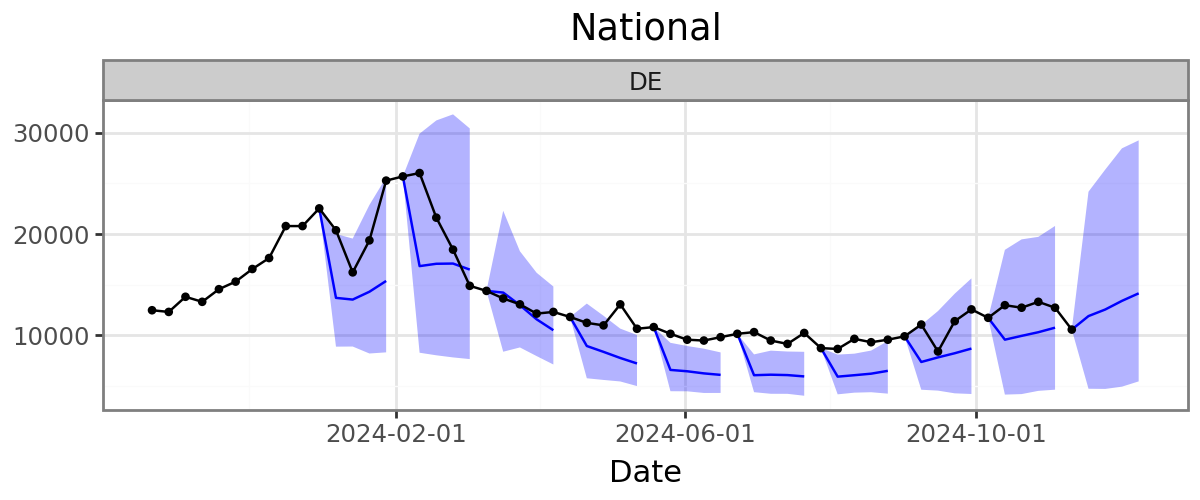

In [193]:
plot_forecasts(df_plot, 'national', start=0)

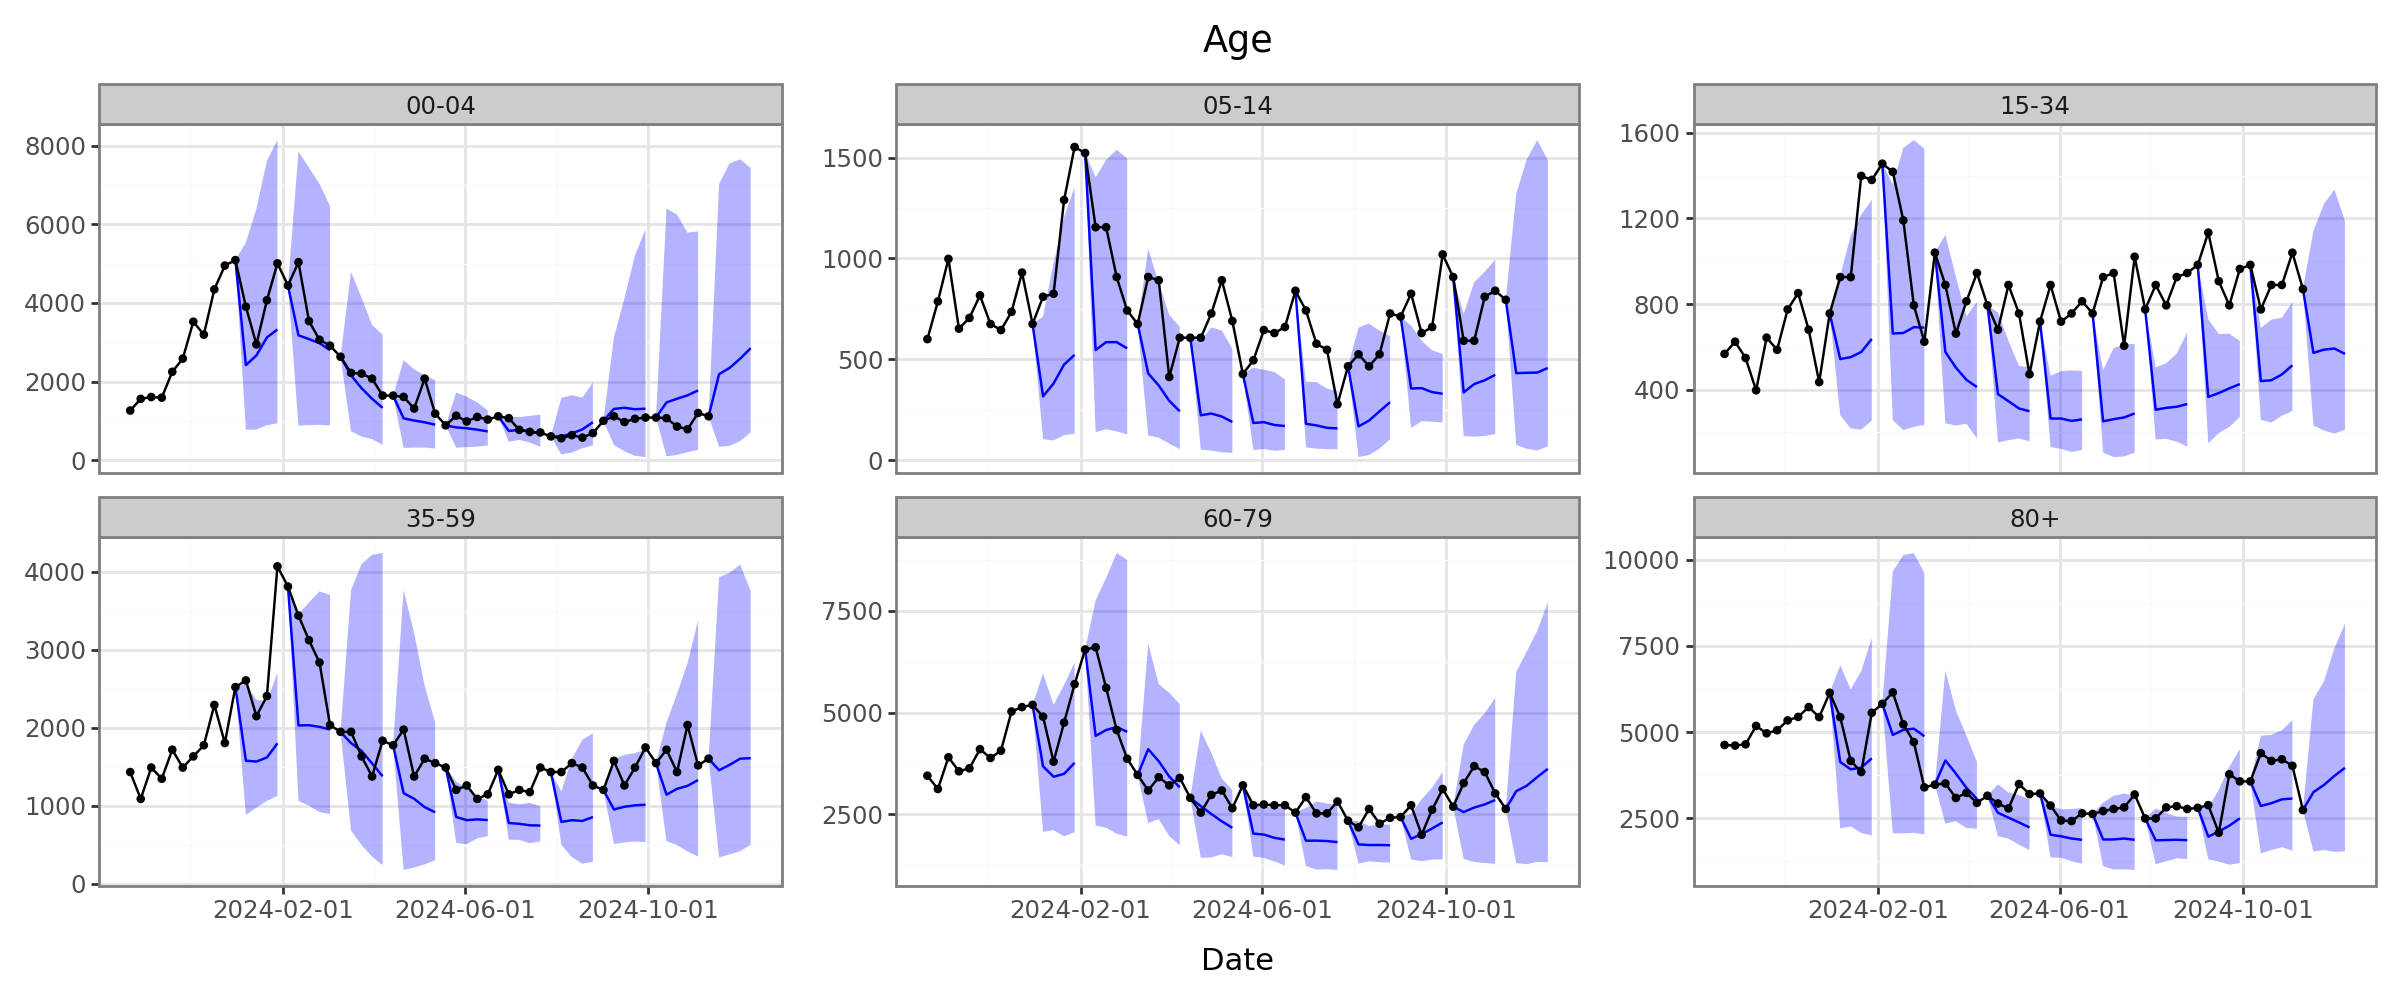

In [194]:
plot_forecasts(df_plot, 'age', start=0)